<a href="https://colab.research.google.com/github/yuikateraoka/AI-image/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#モジュールオブジェクトのインポート
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Input
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras import optimizers
from os import listdir


In [5]:

#イメージサイズの定義をする
image_size = 50

#listdir('./xx/')ファイルの中にある画像を入れる。
path_bh = [filename for filename in listdir('/content/drive/MyDrive/train/rare/') if not filename.startswith('.')]
path_bu = [filename for filename in listdir('/content/drive/MyDrive/train/welldone/') if not filename.startswith('.')]


#各ファイルを順番に呼び出す。（ファイルにある個数分繰り返す。）
#OpenCVで画像サイズをリサイズして統一する。
#img_にリサイズしたものを加える。

img_bh = []
img_bu = []

for i in range(len(path_bh)):
   img = cv2.imread('/content/drive/MyDrive/train/rare/'+ path_bh[i])
   img = cv2.resize(img,(image_size,image_size))
   img_bh.append(img)

for i in range(len(path_bu)):
   img = cv2.imread('/content/drive/MyDrive/train/welldone/'+ path_bu[i])
   img = cv2.resize(img,(image_size,image_size))
   img_bu.append(img)

X = np.array(img_bh + img_bu) #行列をくっつける。
y = np.array([0]*len(img_bh) + [1]*len(img_bu)) #０、１、２と種類ごとに番号をつける。
rand_index = np.random.permutation(np.arange(len(X))) #np.arange(x)の配列をランダムに並べ替えてrand_indexに入れる。
X = X[rand_index] #Xをrand_index順に並び替える
y = y[rand_index] #yをrand_index順に並び替える


#データを分割する。
# X_train = X[:int(len(X)*0.8)].astype(np.float32) #トレーニングデータ８割未満
# y_train = y[:int(len(y)*0.8)].astype(np.float32)
X_train = X[:int(len(X)*0.8)]#トレーニングデータ８割未満
y_train = y[:int(len(y)*0.8)]
X_test = X[int(len(X)*0.8):] #トレーニングデータ以外
y_test = y[int(len(y)*0.8):]

#各属性を表示する。
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_train = to_categorical(y_train) #One-Hotベクトルを作成する。
y_test = to_categorical(y_test) #One-Hotベクトルを作成する。






(912, 50, 50, 3)
(912,)
(229, 50, 50, 3)
(229,)


In [6]:

# 転移学習（VGG16モデル)を活用する。ImageNetで事前学習した重みを読み込む。
input_tensor = Input(shape=(image_size, image_size, 3)) 
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

#特徴抽出部分以降に新しく他の層を追加するにために、あらかじめVGGとは別のモデル（ここではtop_model）を定義する。
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:])) #VGGを結合する。

top_model.add(Dense(256, activation="sigmoid")) #1つ目の全結合層の出力ユニット数は256,活性化関数はshigmoid.
top_model.add(Dropout(0.5))                     #過学習を防ぐ。
top_model.add(Dense(64, activation='sigmoid'))
top_model.add(Dropout(0.5))
top_model.add(Dense(32, activation='sigmoid'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax')) #ソフトマックス関数を用いて3次元で出力する。Dense를 3로 하면 3차원이 된다.

In [21]:
## vgg16とtop_modelを連結してください
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

#15番目の層までは固定し、それ以降のものを繰り返し学習する。
for layer in model.layers[:15]:
   layer.trainable = False

#コンパイルする。
model.compile(loss='categorical_crossentropy', #多クラス分類の損失関数を定義する。
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), #最適化関数を定義する。
             metrics=['accuracy']) #評価関数を定義する。

#X_train, y_trainを用いて学習を行う。テストデータは、X_test, y_test。
# history = model.fit(X_train, y_train, batch_size=32, epochs=75, verbose=1, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, batch_size=15, epochs=25, verbose=1, validation_data=(X_test, y_test))
#精度の評価する。　
score = model.evaluate(X_test, y_test, batch_size=15, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
61/61 [==============================] - 4s 34ms/step - loss: 0.3143 - accuracy: 0.9020 - val_loss: 0.2903 - val_accuracy: 0.8996
Epoch 2/25
61/61 [==============================] - 1s 18ms/step - loss: 0.3440 - accuracy: 0.8569 - val_loss: 0.2913 - val_accuracy: 0.8996
Epoch 3/25
61/61 [==============================] - 1s 18ms/step - loss: 0.3396 - accuracy: 0.8743 - val_loss: 0.2851 - val_accuracy: 0.8996
Epoch 4/25
61/61 [==============================] - 1s 18ms/step - loss: 0.3093 - accuracy: 0.8985 - val_loss: 0.2839 - val_accuracy: 0.8996
Epoch 5/25
61/61 [==============================] - 1s 18ms/step - loss: 0.3130 - accuracy: 0.8912 - val_loss: 0.2870 - val_accuracy: 0.8996
Epoch 6/25
61/61 [==============================] - 1s 19ms/step - loss: 0.2896 - accuracy: 0.9144 - val_loss: 0.2831 - val_accuracy: 0.8996
Epoch 7/25
61/61 [==============================] - 1s 18ms/step - loss: 0.3269 - accuracy: 0.8802 - val_loss: 0.2832 - val_accuracy: 0.8996
Epoch 8/25
61

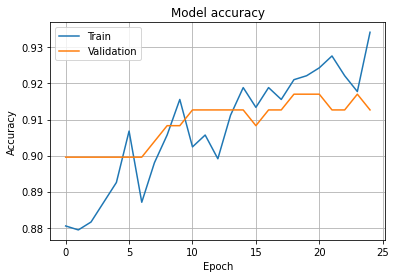

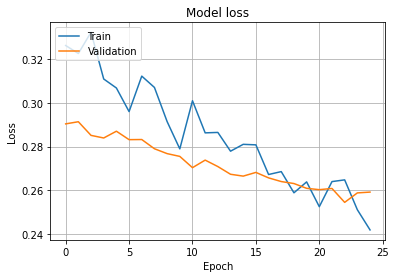

NameError: ignored

In [22]:
#plt.plot(history.history['acc'])
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）') 
print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）') 
print('Computation time（計算時間）:{0:.3f} sec（秒）'.format(time.time() - start_time))

In [26]:

#モデルを保存する。
model.save("my_model4.h5")